# Imports et déclaration de fonctions

In [134]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import missingno as msno
import seaborn as sns

In [135]:
def automate_data_processing(df, target_column, missing_value_threshold=0.5):
    threshold = len(df) * missing_value_threshold
    df_cleaned = df.dropna(thresh=threshold, axis=1)
    
    df_cleaned = df_cleaned.dropna(subset=[target_column])
    df_cleaned['pnns_groups_1'] = df['pnns_groups_1']
    df_cleaned['pnns_groups_2'] = df['pnns_groups_2']
    y = df_cleaned[target_column]
    X = df_cleaned.drop(columns=[target_column])

    df_cleaned = df_cleaned.drop_duplicates()
    
    return df_cleaned, X, y
    

def clean_outliers(df):
    cols_100g = [col for col in df.columns if col.endswith('_100g')]

    df[cols_100g] = df[cols_100g].applymap(lambda x: abs(x) if pd.notnull(x) else x)

    nutrient_thresholds = {
        'energy_100g': 4000,
        'fat_100g': 100,
        'saturated-fat_100g': 90,
        'carbohydrates_100g': 100,
        'sugars_100g': 100,
        'fiber_100g': 45,
        'proteins_100g': 90,
        'salt_100g': 10,
        'sodium_100g': 6
    }

    for col in cols_100g:
        threshold = nutrient_thresholds.get(col, 100)
        df[col] = df[col].apply(lambda x: x if x <= threshold else float('NaN'))

    return df

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

def impute_nutritions_features(df, features_map):
    for feature, (categories, subcategories) in features_map.items():
        df.loc[df['pnns_groups_1'].isin(categories), feature] = \
            df.loc[df['pnns_groups_1'].isin(categories), feature].fillna(0)       
        df.loc[df['pnns_groups_2'].isin(subcategories), feature] = \
            df.loc[df['pnns_groups_2'].isin(subcategories), feature].fillna(0)
    return df

def impute_by_category_median(df, features, primary_category, secondary_category):
    for feature in features:
        if feature in df.columns:
            df[feature] = df[feature].where(
                df[feature].notnull(),
                df.groupby(secondary_category)[feature].transform('median')
            )
            df[feature] = df[feature].where(
                df[feature].notnull(),
                df.groupby(primary_category)[feature].transform('median')
            )
    return df

In [136]:
df = pd.read_csv('/kaggle/input/projet-dataset/data.csv', sep='\t')
df.head();

/tmp/ipykernel_30/1579681762.py:1: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/input/projet-dataset/data.csv', sep='\t')


# Premiers traitements du dataset

In [137]:
df.shape

(320772, 162)

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


On voit que nous avons **106 données quantitatives** et **56 données catégorielles**

**Affichage des proportions de valeurs manquantes**

In [139]:
df.isna().mean()

code                       0.000072
url                        0.000072
creator                    0.000006
created_t                  0.000009
created_datetime           0.000028
                             ...   
carbon-footprint_100g      0.999165
nutrition-score-fr_100g    0.310382
nutrition-score-uk_100g    0.310382
glycemic-index_100g        1.000000
water-hardness_100g        1.000000
Length: 162, dtype: float64

**Appel de la fonction de préparation des données**

Notre target sera le Nutriscore qui peut facilement être prédit en fonction des qualités nutritives du produit tels que le sucre, le sel, les acides gras saturés, les protéines, etc...

In [140]:
target = 'nutrition_grade_fr'
df_cleaned, X, y = automate_data_processing(df, target)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221210 entries, 1 to 320768
Data columns (total 36 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   code                                     221210 non-null  object 
 1   url                                      221210 non-null  object 
 2   creator                                  221210 non-null  object 
 3   created_t                                221210 non-null  object 
 4   created_datetime                         221209 non-null  object 
 5   last_modified_t                          221210 non-null  object 
 6   last_modified_datetime                   221210 non-null  object 
 7   product_name                             218463 non-null  object 
 8   brands                                   216572 non-null  object 
 9   brands_tags                              216571 non-null  object 
 10  countries                            

Il nous reste après le nettoyage des valeurs manquantes **14 données quantitatives** et **22 données catégorielles**.

**Drop des features inutiles**

In [141]:
excluded_columns = ['pnns_groups_1', 'pnns_groups_2', 'nutrition_grade_fr']
non_numeric_columns = df_cleaned.select_dtypes(exclude=['number']).columns

columns_to_drop = [col for col in non_numeric_columns if col not in excluded_columns]

df_cleaned = df_cleaned.drop(columns=columns_to_drop)

In [142]:
df_cleaned = df_cleaned.drop_duplicates()

In [143]:
df_cleaned.shape

(174494, 17)

In [144]:
df_cleaned.info();

<class 'pandas.core.frame.DataFrame'>
Index: 174494 entries, 1 to 320757
Data columns (total 17 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   additives_n                              150597 non-null  float64
 1   ingredients_from_palm_oil_n              150597 non-null  float64
 2   ingredients_that_may_be_from_palm_oil_n  150597 non-null  float64
 3   nutrition_grade_fr                       174494 non-null  object 
 4   energy_100g                              174411 non-null  float64
 5   fat_100g                                 157975 non-null  float64
 6   saturated-fat_100g                       174411 non-null  float64
 7   carbohydrates_100g                       157945 non-null  float64
 8   sugars_100g                              174411 non-null  float64
 9   fiber_100g                               150454 non-null  float64
 10  proteins_100g                        

**Premiere Visualisation**

In [145]:
df_cleaned.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,150597.000000,150597.000000,150597.000000,1.744110e+05,157975.000000,174411.000000,157945.000000,174411.000000,150454.000000,174411.000000,174411.000000,174411.000000,174494.000000,174494.000000
mean,2.116018,0.027052,0.068467,1.194869e+03,13.251224,4.997881,33.105992,15.143134,2.846796,7.610106,1.782759,0.701874,9.352551,9.217297
std,2.630784,0.164108,0.301495,7.856719e+03,15.363121,7.546890,27.408764,21.062909,14.572812,7.866032,154.676524,60.896269,8.921376,9.062442
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-17.860000,0.000000,-3.570000,0.000000,0.000000,-15.000000,-15.000000
25%,0.000000,0.000000,0.000000,4.810000e+02,1.210000,0.000000,7.650000,1.480000,0.000000,2.200000,0.119380,0.047000,1.000000,1.000000
50%,1.000000,0.000000,0.000000,1.146000e+03,7.960000,2.000000,25.000000,5.600000,1.500000,5.710000,0.680720,0.268000,10.000000,10.000000
75%,3.000000,0.000000,0.000000,1.724000e+03,21.430000,7.140000,57.140000,23.610000,3.600000,10.500000,1.361440,0.536000,16.000000,16.000000
max,31.000000,2.000000,6.000000,3.251373e+06,714.290000,550.000000,209.380000,3520.000000,5380.000000,430.000000,64312.800000,25320.000000,40.000000,40.000000


In [146]:
df_cleaned[target].isna().mean()

0.0

In [147]:
df_cleaned.isna().mean()

additives_n                                0.136950
ingredients_from_palm_oil_n                0.136950
ingredients_that_may_be_from_palm_oil_n    0.136950
nutrition_grade_fr                         0.000000
energy_100g                                0.000476
fat_100g                                   0.094668
saturated-fat_100g                         0.000476
carbohydrates_100g                         0.094840
sugars_100g                                0.000476
fiber_100g                                 0.137770
proteins_100g                              0.000476
salt_100g                                  0.000476
sodium_100g                                0.000476
nutrition-score-fr_100g                    0.000000
nutrition-score-uk_100g                    0.000000
pnns_groups_1                              0.673782
pnns_groups_2                              0.673204
dtype: float64

In [148]:
display(df_cleaned.columns)

Index(['additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
       'pnns_groups_1', 'pnns_groups_2'],
      dtype='object')

On drop les features qui ne serviront plus

In [149]:
df_cleaned = df_cleaned.drop(columns=['nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'ingredients_that_may_be_from_palm_oil_n'])

# Affichage des données

**Vérification des valeurs extrêmes**

In [150]:
df_cleaned.describe()

,additives_n,ingredients_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
count,150597.000000,150597.000000,1.744110e+05,157975.000000,174411.000000,157945.000000,174411.000000,150454.000000,174411.000000,174411.000000,174411.000000
mean,2.116018,0.027052,1.194869e+03,13.251224,4.997881,33.105992,15.143134,2.846796,7.610106,1.782759,0.701874
std,2.630784,0.164108,7.856719e+03,15.363121,7.546890,27.408764,21.062909,14.572812,7.866032,154.676524,60.896269
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-17.860000,0.000000,-3.570000,0.000000,0.000000
25%,0.000000,0.000000,4.810000e+02,1.210000,0.000000,7.650000,1.480000,0.000000,2.200000,0.119380,0.047000
50%,1.000000,0.000000,1.146000e+03,7.960000,2.000000,25.000000,5.600000,1.500000,5.710000,0.680720,0.268000
75%,3.000000,0.000000,1.724000e+03,21.430000,7.140000,57.140000,23.610000,3.600000,10.500000,1.361440,0.536000
max,31.000000,2.000000,3.251373e+06,714.290000,550.000000,209.380000,3520.000000,5380.000000,430.000000,64312.800000,25320.000000


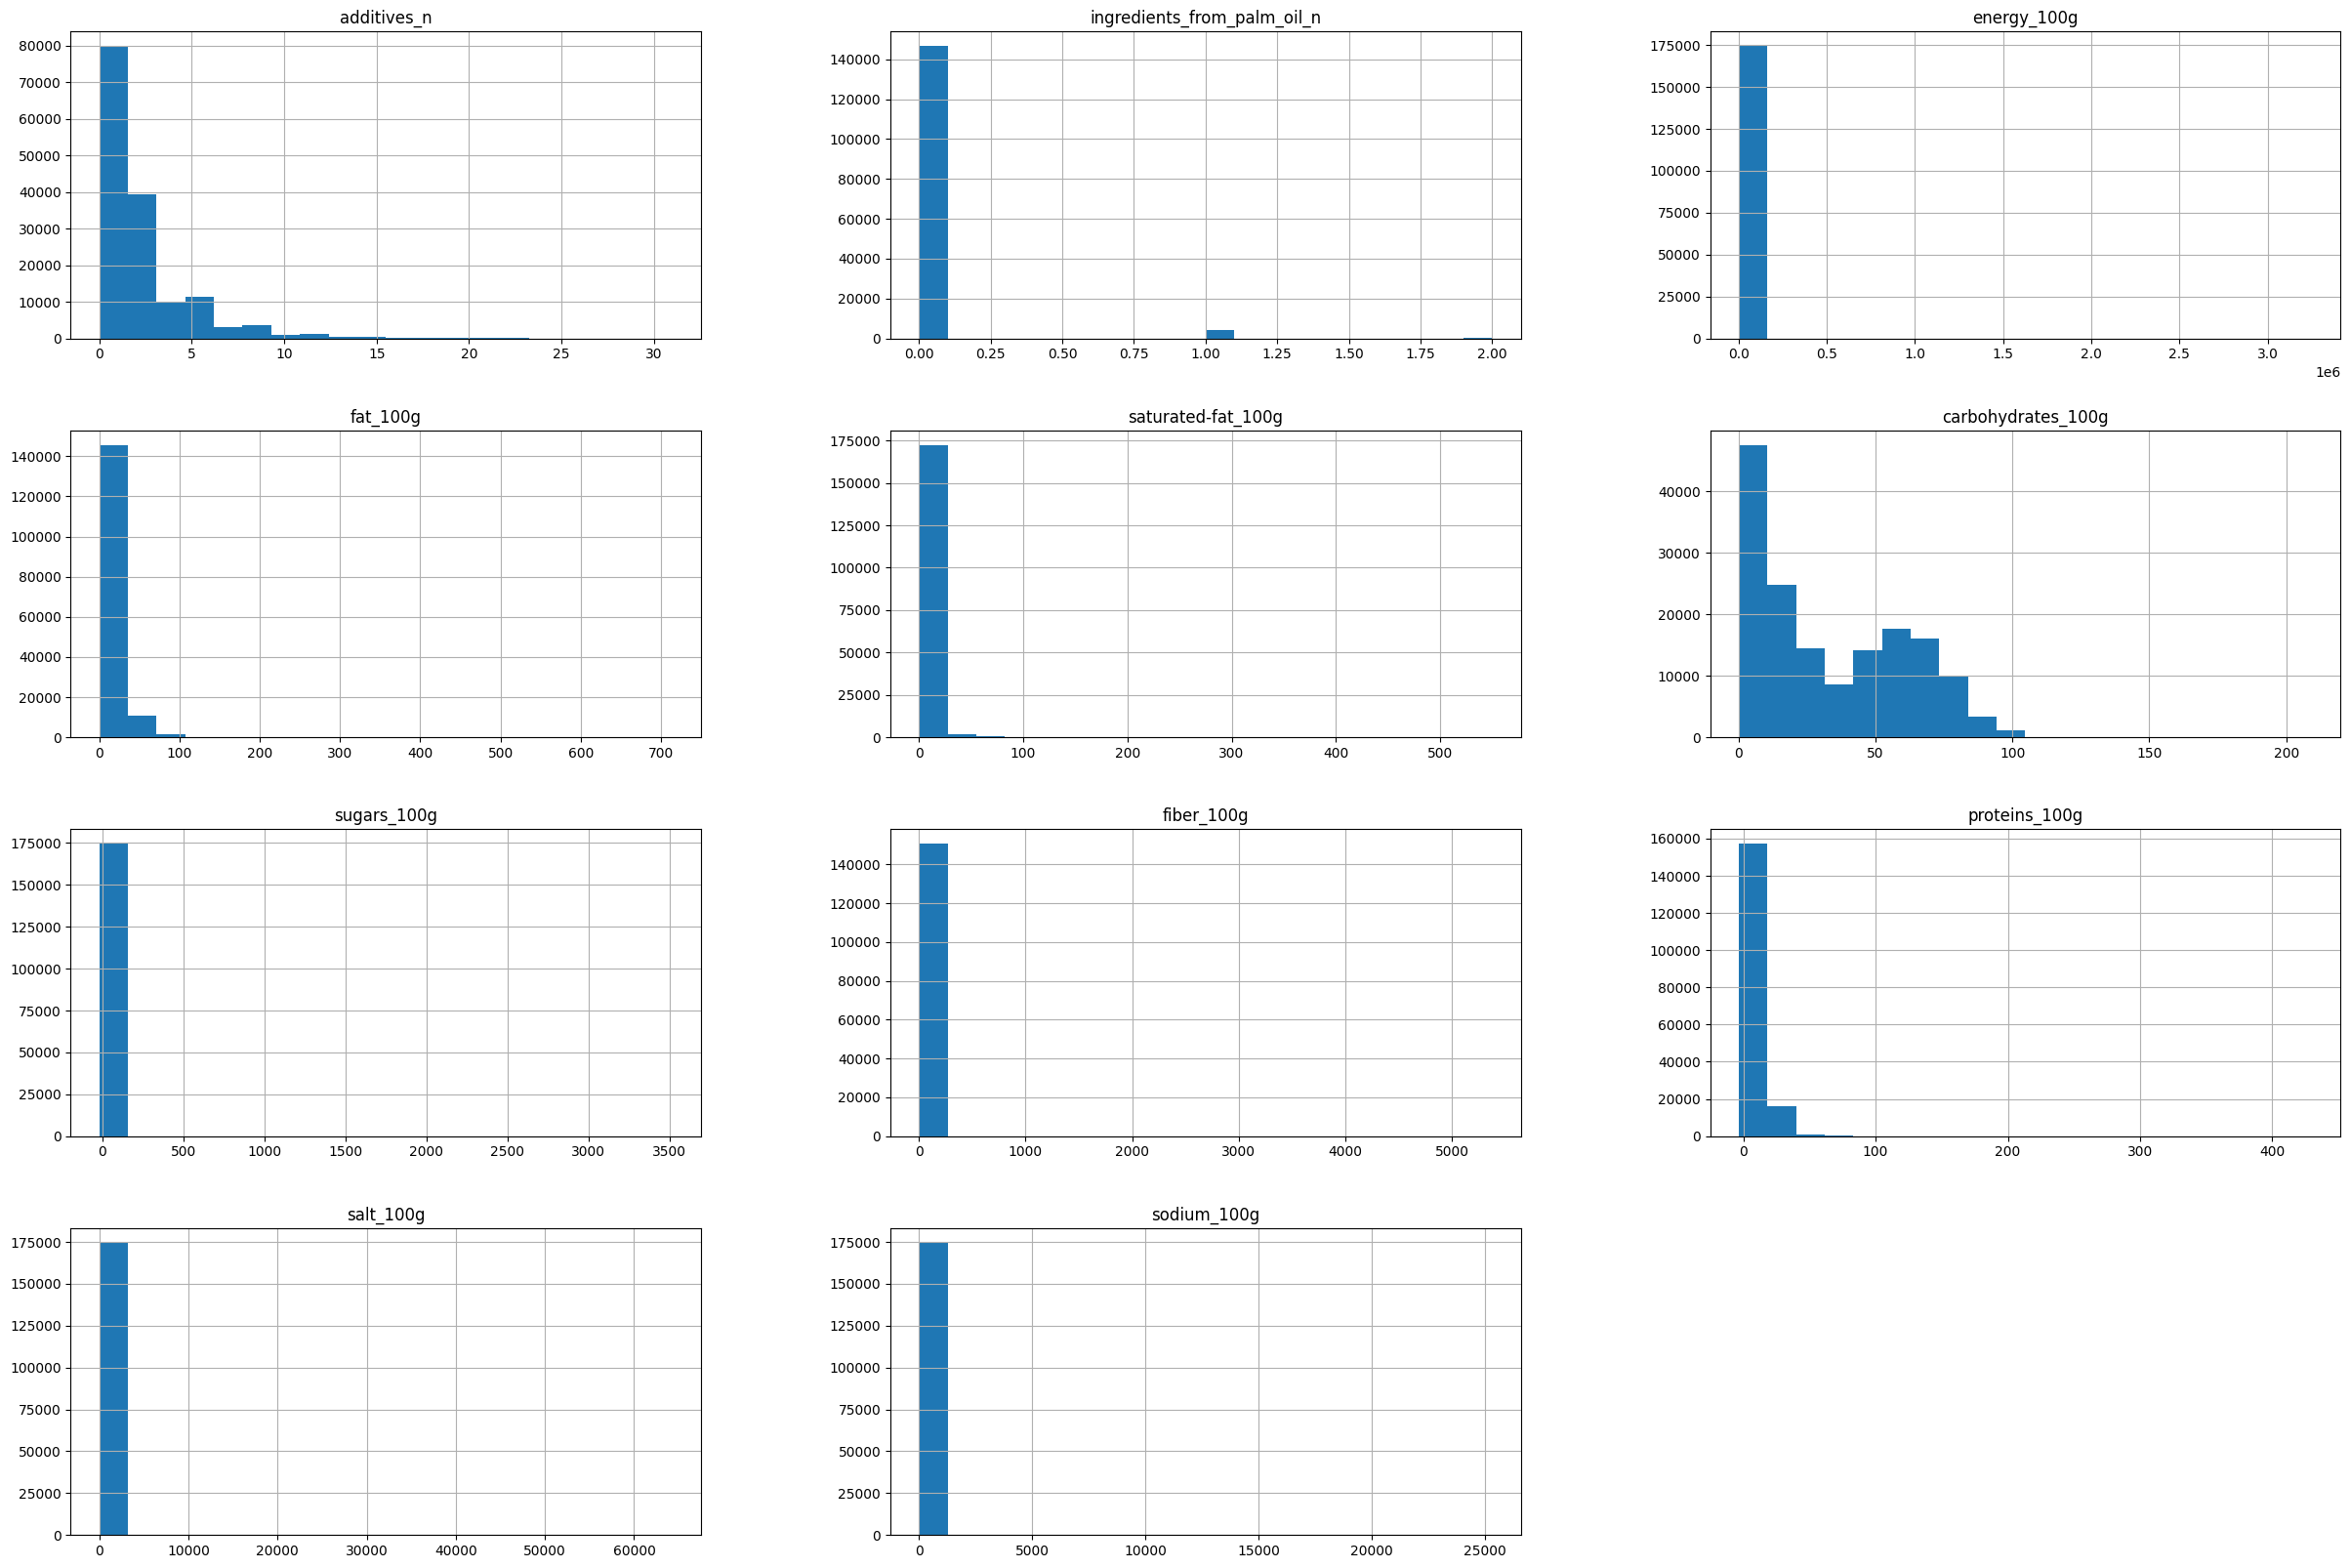

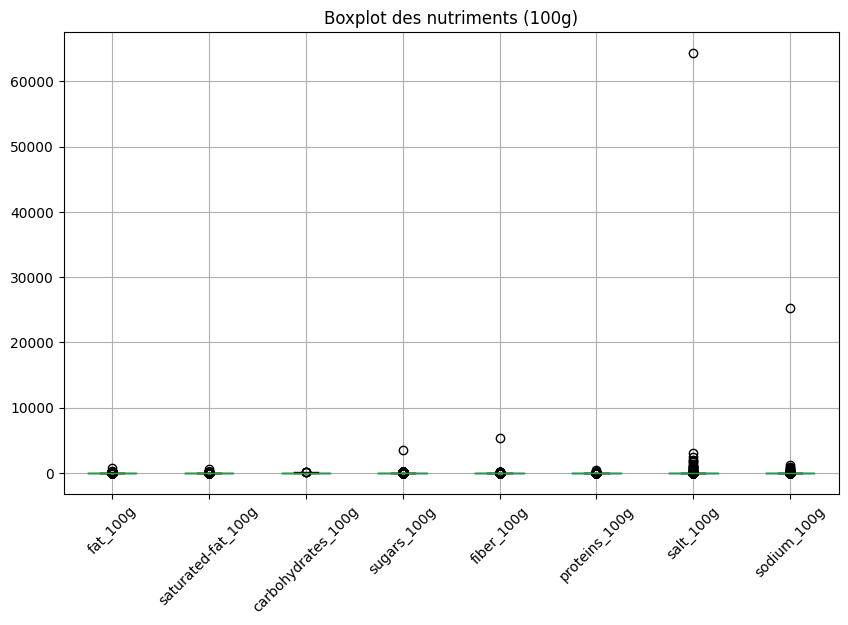

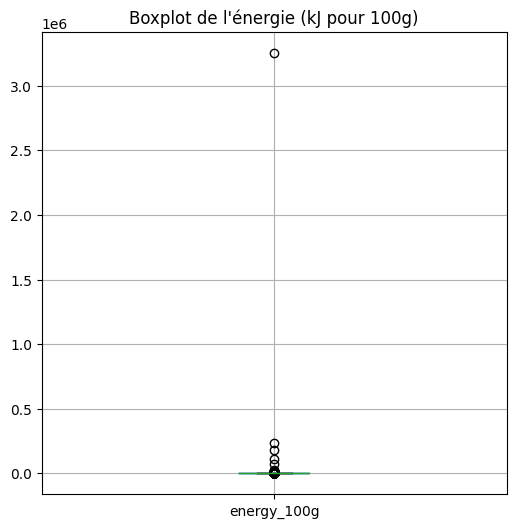

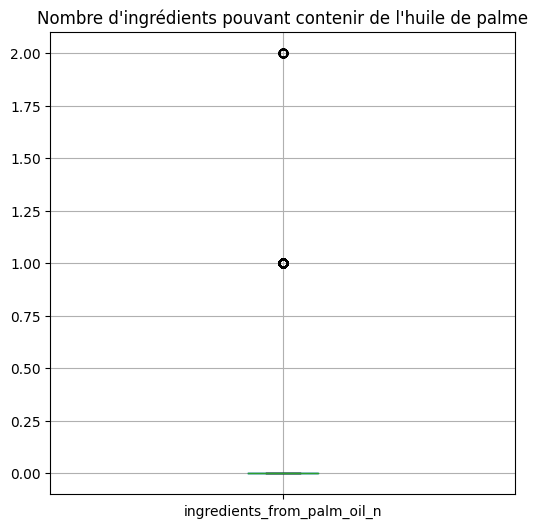

In [151]:
df_cleaned.hist(bins=20, figsize=(30, 20))
plt.show()

nutriment_features = [col for col in df_cleaned.columns if col.endswith('_100g') and col != 'energy_100g']

# Nutriments
plt.figure(figsize=(10, 6))
df_cleaned[nutriment_features].boxplot() 
plt.title("Boxplot des nutriments (100g)")
plt.xticks(rotation=45)
plt.show()

# Energie
plt.figure(figsize=(6, 6))
df_cleaned[['energy_100g']].boxplot()
plt.title("Boxplot de l'énergie (kJ pour 100g)")
plt.show()

# Huile de palme
plt.figure(figsize=(6, 6))
df_cleaned[['ingredients_from_palm_oil_n']].boxplot()
plt.title("Nombre d'ingrédients pouvant contenir de l'huile de palme")
plt.show()

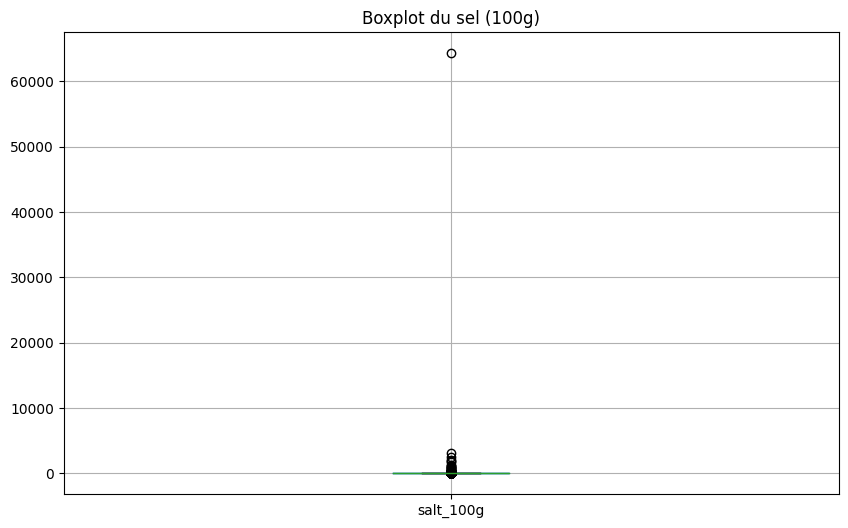

(array([1]), [Text(1, 0, 'sodium_100g')])

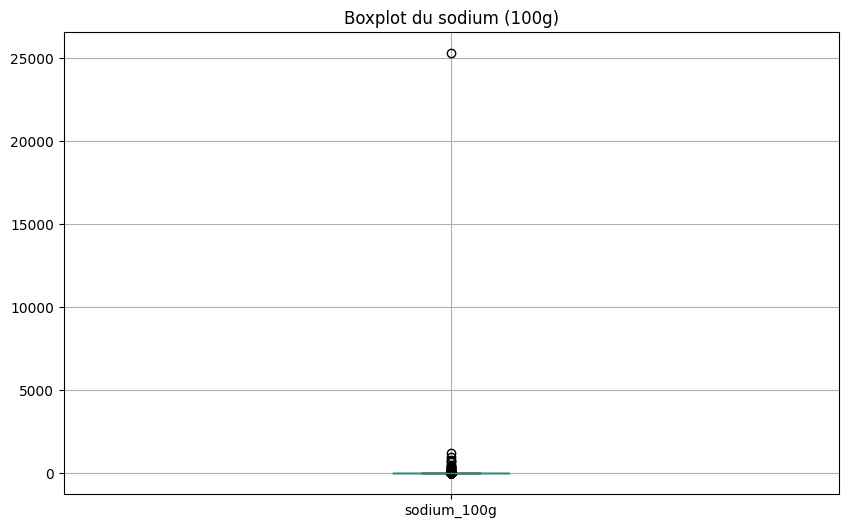

In [152]:
plt.figure(figsize=(10, 6))
df_cleaned[['salt_100g']].boxplot() 
plt.title("Boxplot du sel (100g)")
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(10, 6))
df_cleaned[['sodium_100g']].boxplot() 
plt.title("Boxplot du sodium (100g)")
plt.xticks(rotation=0)

pnns_groups_1
Fish Meat Eggs             595
unknown                    558
Fat and sauces             356
Cereals and potatoes        55
Fruits and vegetables       33
Salty snacks                32
Composite foods             23
Milk and dairy products     18
Beverages                   14
Sugary snacks               13
Name: count, dtype: int64


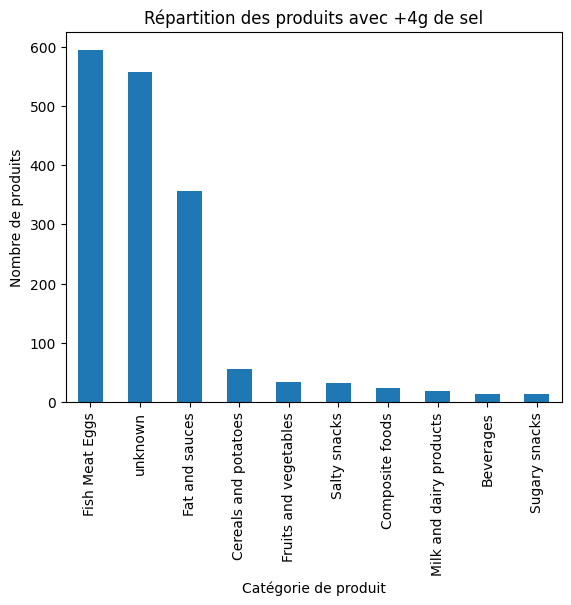

In [153]:
salt_category = df_cleaned[df_cleaned['salt_100g'] >= 4]

print(salt_category['pnns_groups_1'].value_counts())
salt_category['pnns_groups_1'].value_counts().plot(kind='bar')
plt.xlabel("Catégorie de produit")
plt.ylabel("Nombre de produits")
plt.xticks(rotation=90)
plt.title("Répartition des produits avec +4g de sel")
plt.show()

pnns_groups_1
unknown                    385
Fat and sauces             272
Fish Meat Eggs             206
Cereals and potatoes        33
Composite foods             17
Fruits and vegetables       16
Beverages                   12
Sugary snacks               11
Salty snacks                 8
Milk and dairy products      4
Name: count, dtype: int64


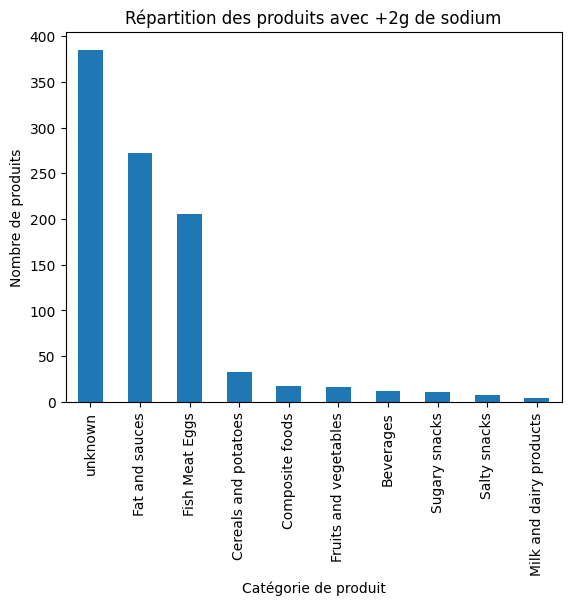

In [154]:
sodium_category = df_cleaned[df_cleaned['sodium_100g'] >= 2]

print(sodium_category['pnns_groups_1'].value_counts())
sodium_category['pnns_groups_1'].value_counts().plot(kind='bar')
plt.xlabel("Catégorie de produit")
plt.ylabel("Nombre de produits")
plt.xticks(rotation=90)
plt.title("Répartition des produits avec +2g de sodium")
plt.show()

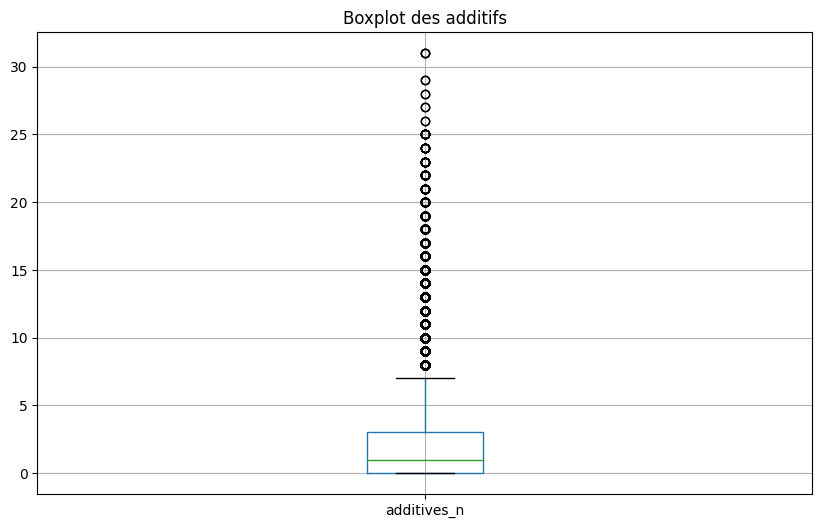

In [155]:
plt.figure(figsize=(10, 6))
df_cleaned[['additives_n']].boxplot() 
plt.title("Boxplot des additifs")
plt.show()

pnns_groups_1
Sugary snacks              1559
unknown                     604
Cereals and potatoes        394
Composite foods             250
Salty snacks                154
Fat and sauces              118
Milk and dairy products     105
sugary-snacks                73
Fish Meat Eggs               23
Fruits and vegetables        10
Beverages                     9
fruits-and-vegetables         2
Name: count, dtype: int64


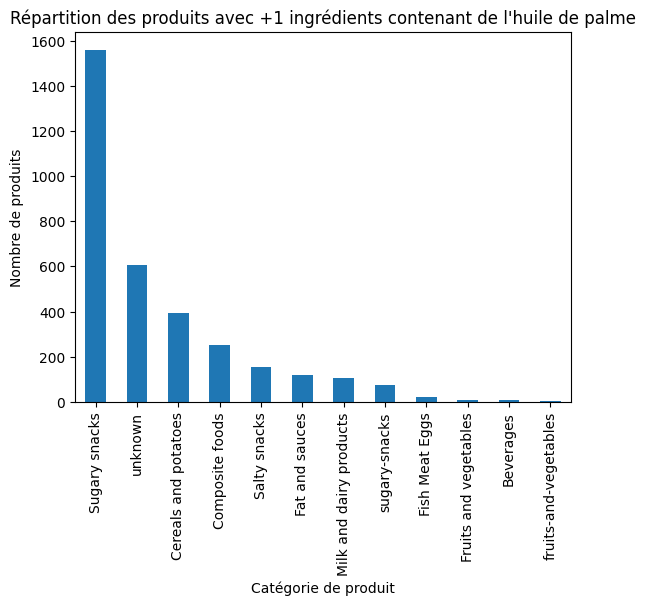

In [156]:
palm_oil_ingredients = df_cleaned[df_cleaned['ingredients_from_palm_oil_n'] >= 1]

print(palm_oil_ingredients['pnns_groups_1'].value_counts())
palm_oil_ingredients['pnns_groups_1'].value_counts().plot(kind='bar')
plt.xlabel("Catégorie de produit")
plt.ylabel("Nombre de produits")
plt.xticks(rotation=90)
plt.title("Répartition des produits avec +1 ingrédients contenant de l'huile de palme")
plt.show()

pnns_groups_1
Fat and sauces             164
unknown                     29
Sugary snacks                8
Fish Meat Eggs               4
Beverages                    3
Milk and dairy products      3
Salty snacks                 2
Cereals and potatoes         2
Fruits and vegetables        1
sugary-snacks                1
Name: count, dtype: int64


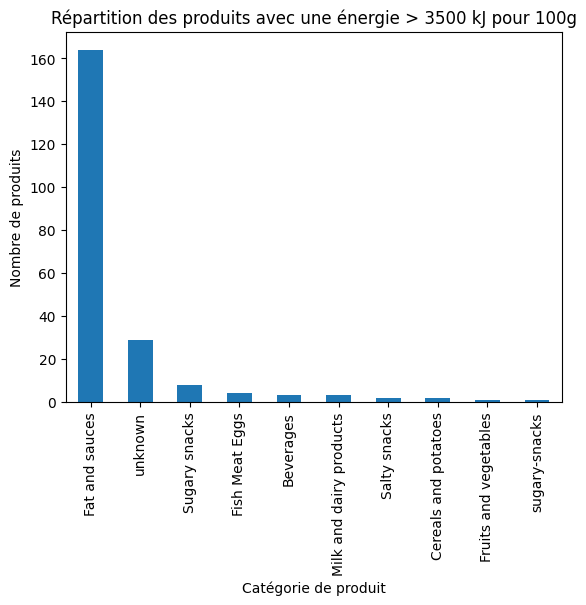

In [157]:
energy_threshold = 3500

high_energy_products = df_cleaned[df_cleaned['energy_100g'] > energy_threshold]

print(high_energy_products['pnns_groups_1'].value_counts())

high_energy_products['pnns_groups_1'].value_counts().plot(kind='bar')
plt.xlabel("Catégorie de produit")
plt.ylabel("Nombre de produits")
plt.title("Répartition des produits avec une énergie > 3500 kJ pour 100g")
plt.show()

pnns_groups_1
unknown                    383
Fat and sauces             269
Fish Meat Eggs             194
Cereals and potatoes        32
Composite foods             17
Fruits and vegetables       15
Beverages                   12
Sugary snacks               11
Salty snacks                 8
Milk and dairy products      4
Name: count, dtype: int64


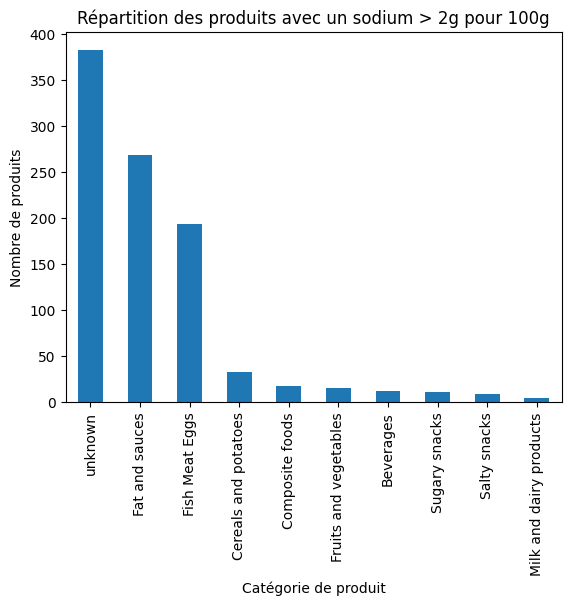

In [158]:
sodium_threshold = 2

high_sodium_products = df_cleaned[df_cleaned['sodium_100g'] > sodium_threshold]

print(high_sodium_products['pnns_groups_1'].value_counts())

high_sodium_products['pnns_groups_1'].value_counts().plot(kind='bar')
plt.xlabel("Catégorie de produit")
plt.ylabel("Nombre de produits")
plt.title("Répartition des produits avec un sodium > 2g pour 100g")
plt.show()

pnns_groups_1
Fish Meat Eggs             545
unknown                    524
Fat and sauces             347
Cereals and potatoes        54
Fruits and vegetables       32
Salty snacks                28
Composite foods             21
Beverages                   14
Sugary snacks               13
Milk and dairy products     11
Name: count, dtype: int64


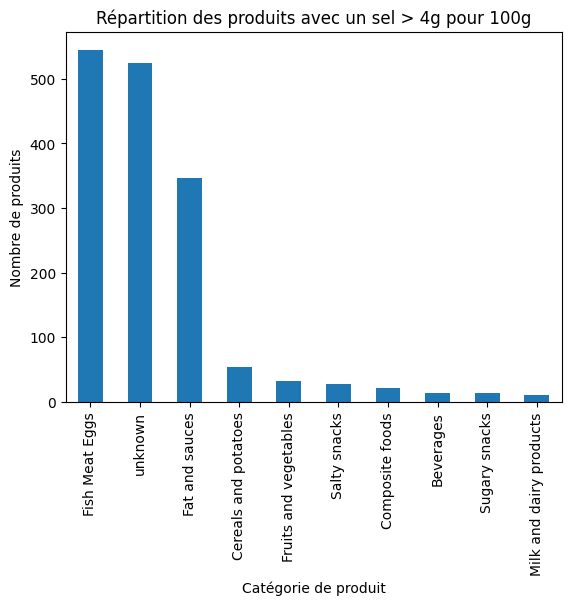

In [159]:
salt_threshold = 4

high_salt_products = df_cleaned[df_cleaned['salt_100g'] > salt_threshold]

print(high_salt_products['pnns_groups_1'].value_counts())

high_salt_products['pnns_groups_1'].value_counts().plot(kind='bar')
plt.xlabel("Catégorie de produit")
plt.ylabel("Nombre de produits")
plt.title("Répartition des produits avec un sel > 4g pour 100g")
plt.show()

On supprime dans un premier temps les lignes ayant des valeurs aberrerantes d'un pdv métier

In [160]:
df_cleaned = clean_outliers(df_cleaned)

/tmp/ipykernel_30/2533392912.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cols_100g] = df[cols_100g].applymap(lambda x: abs(x) if pd.notnull(x) else x)


In [161]:
print(df_cleaned.isnull().mean())

additives_n                    0.136950
ingredients_from_palm_oil_n    0.136950
nutrition_grade_fr             0.000000
energy_100g                    0.001163
fat_100g                       0.094691
saturated-fat_100g             0.000774
carbohydrates_100g             0.094903
sugars_100g                    0.000516
fiber_100g                     0.138549
proteins_100g                  0.000562
salt_100g                      0.012694
sodium_100g                    0.008115
pnns_groups_1                  0.673782
pnns_groups_2                  0.673204
dtype: float64


<Axes: >

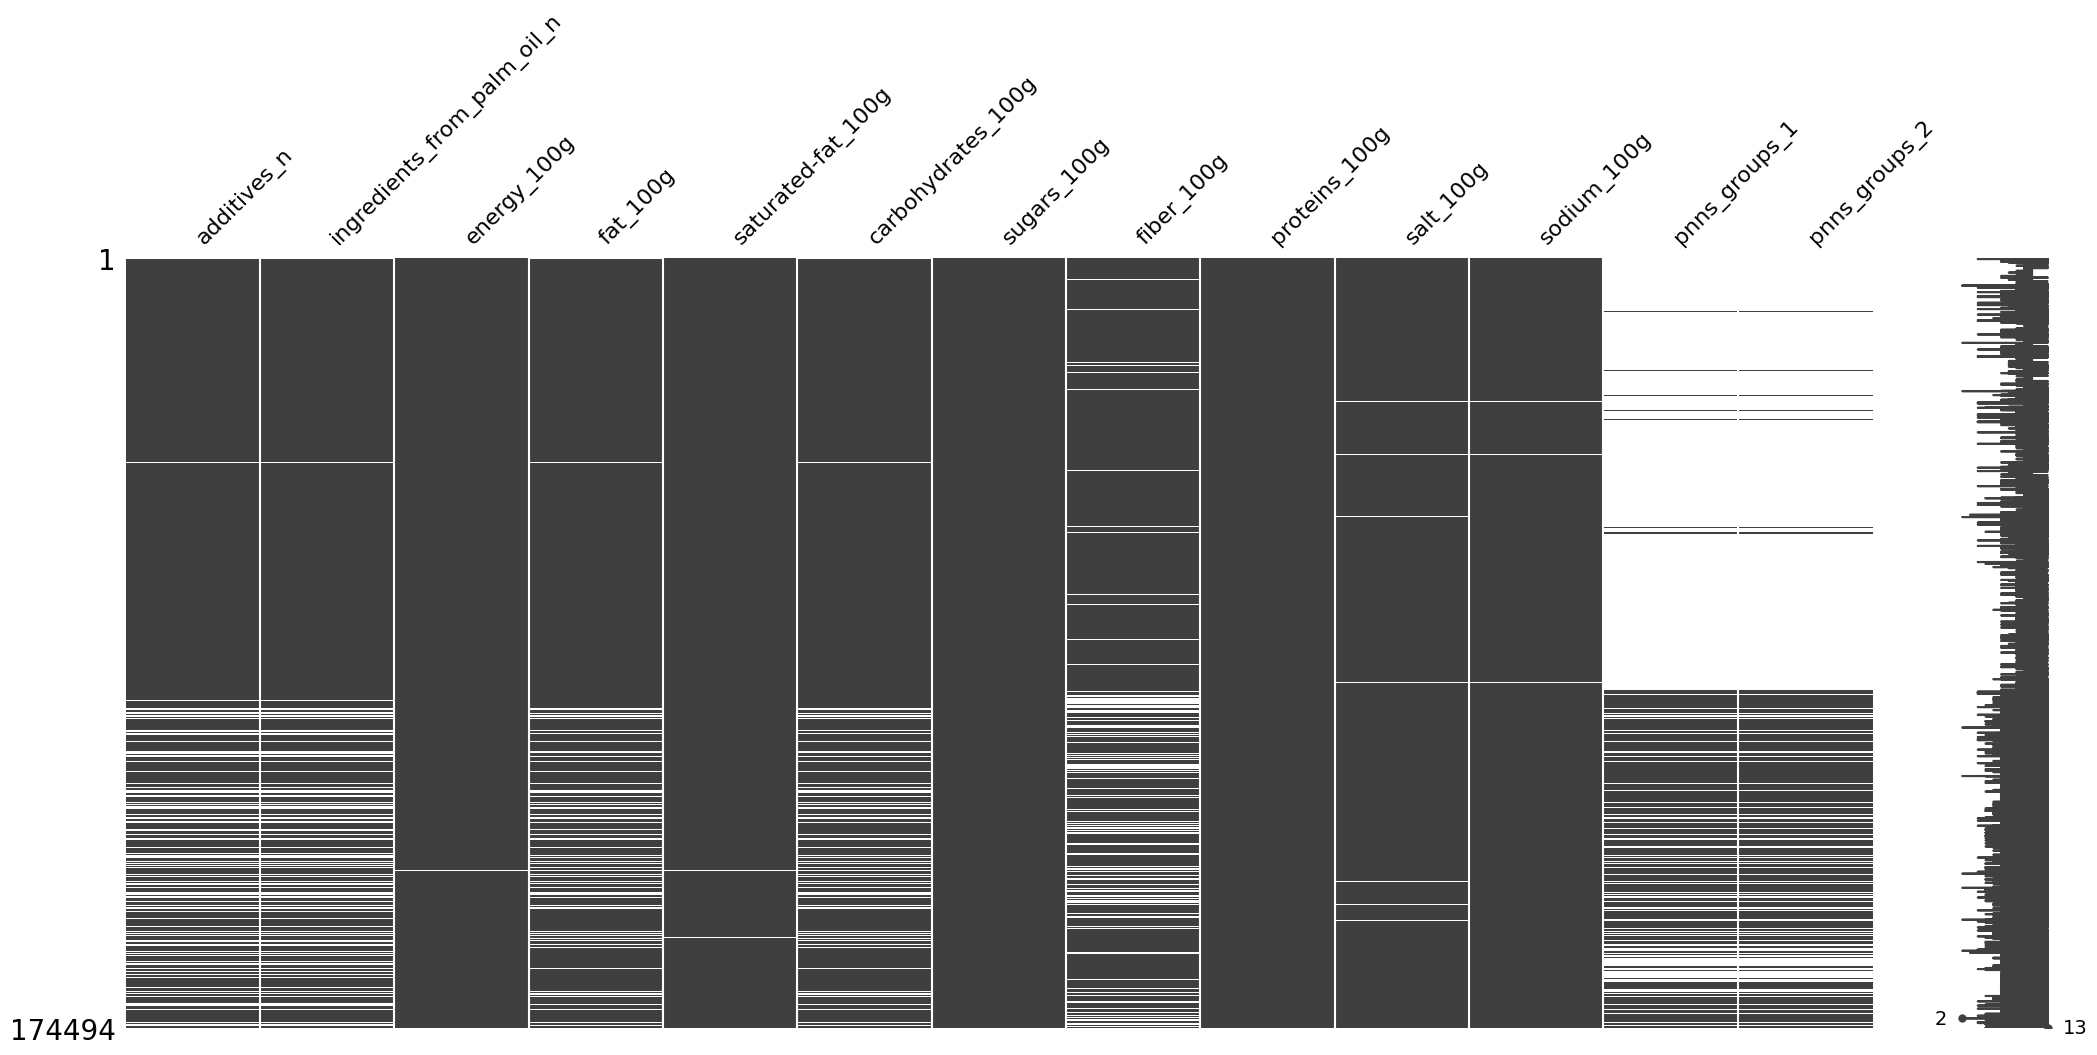

In [162]:
msno.matrix(df_cleaned[df_cleaned.columns[df_cleaned.isnull().any()]])

# Imputation des valeurs manquantes

**Affichage des catégories**

In [163]:
unique_values = df_cleaned['pnns_groups_1'].unique()

print("Valeurs uniques dans la colonne 'pnns_groups_1' :")
print(unique_values)

Valeurs uniques dans la colonne 'pnns_groups_1' :
[nan 'unknown' 'Fruits and vegetables' 'Sugary snacks' 'Composite foods'
 'Beverages' 'Fish Meat Eggs' 'Fat and sauces' 'Cereals and potatoes'
 'Milk and dairy products' 'Salty snacks' 'fruits-and-vegetables'
 'sugary-snacks' 'cereals-and-potatoes' 'salty-snacks']


In [164]:
unique_values = df_cleaned['pnns_groups_2'].unique()

print("Valeurs uniques dans la colonne 'pnns_groups_2' :")
print(unique_values)

Valeurs uniques dans la colonne 'pnns_groups_2' :
[nan 'unknown' 'Vegetables' 'Biscuits and cakes' 'Pizza pies and quiche'
 'Sweets' 'Sweetened beverages' 'One-dish meals' 'Soups' 'Meat'
 'Dressings and sauces' 'Cereals' 'Fruits' 'Milk and yogurt' 'Fats'
 'Non-sugared beverages' 'Cheese' 'Chocolate products' 'Sandwich' 'Bread'
 'Nuts' 'Legumes' 'Breakfast cereals' 'Appetizers' 'Fruit juices' 'Eggs'
 'Fish and seafood' 'Dried fruits' 'Ice cream' 'Processed meat'
 'vegetables' 'pastries' 'Dairy desserts' 'Alcoholic beverages' 'Potatoes'
 'Artificially sweetened beverages' 'Fruit nectars' 'fruits'
 'Salty and fatty products' 'Tripe dishes' 'cereals' 'legumes' 'nuts']


**Uniformisation des catégories**

In [165]:
df_cleaned = df_cleaned.replace('fruits-and-vegetables', 'Fruits and vegetables')
df_cleaned = df_cleaned.replace('sugary-snacks', 'Sugary snacks')
df_cleaned = df_cleaned.replace('salty-snacks', 'Salty snacks')
df_cleaned = df_cleaned.replace('cereals-and-potatoes', 'Cereals and potatoes')

df_cleaned = df_cleaned.replace('legumes', 'Legumes')
df_cleaned = df_cleaned.replace('nuts', 'Nuts')
df_cleaned = df_cleaned.replace('vegetables', 'Vegetables')
df_cleaned = df_cleaned.replace('cereals', 'Cereals')
df_cleaned = df_cleaned.replace('fruits', 'Fruits')
df_cleaned = df_cleaned.replace('pastries', 'Pastries')

**Définition des catégories imputable à 0**

In [166]:
fiber_categories = ['Beverages', 'Fish Meat Eggs', 'Fat and sauces', 'Milk and dairy products']
fiber_subcategories = [
    'Meat', 'Fish and seafood', 'Eggs', 'Cheese', 'Processed meat', 
    'Fats', 'Dairy desserts', 'Milk and yogurt', 'Sweetened beverages', 
    'Non-sugared beverages', 'Alcoholic beverages', 'Fruit juices', 
    'Artificially sweetened beverages', 'Fruit nectars', 'Dressings and sauces', 
    'Chocolate products', 'Ice cream', 'Sweets', 'Salty and fatty products', 
    'Tripe dishes'
]

carbohydrate_categories = ['Fish Meat Eggs', 'Fat and sauces', 'Milk and dairy products', 'Beverages']
carbohydrate_subcategories = [
    'Meat', 'Fish and seafood', 'Eggs', 'Cheese', 'Processed meat', 
    'Fats', 'Milk and yogurt', 'Non-sugared beverages', 'Alcoholic beverages', 
    'Artificially sweetened beverages', 'Dressings and sauces', 'Tripe dishes'
]

sugar_categories = ['Fish Meat Eggs', 'Fat and sauces', 'Milk and dairy products', 'Beverages']
sugar_subcategories = [
    'Meat', 'Fish and seafood', 'Eggs', 'Cheese', 'Processed meat', 
    'Fats', 'Non-sugared beverages', 'Alcoholic beverages', 
    'Artificially sweetened beverages', 'Dressings and sauces', 'Tripe dishes'
]

saturated_fat_categories = ['Fruits and vegetables', 'Beverages']
saturated_fat_subcategories = [
    'Vegetables', 'Fruits', 'Non-sugared beverages', 'Alcoholic beverages', 
    'Artificially sweetened beverages', 'Fruit juices', 'Fruit nectars'
]

fat_categories = ['Beverages', 'Fruits and vegetables', 'Cereals and potatoes']
fat_subcategories = [
    'Vegetables', 'Fruits', 'Cereals', 'Potatoes', 'Non-sugared beverages', 
    'Sweetened beverages', 'Alcoholic beverages', 'Artificially sweetened beverages', 
    'Fruit juices', 'Fruit nectars'
]

protein_categories = ['Fat and sauces', 'Sugary snacks', 'Beverages']
protein_subcategories = [
    'Fats', 'Dressings and sauces', 'Sweets', 'Sweetened beverages', 
    'Non-sugared beverages', 'Artificially sweetened beverages', 
    'Alcoholic beverages', 'Fruit juices', 'Fruit nectars', 'Ice cream'
]

sodium_categories = ['Beverages']
salt_categories = sodium_categories

sodium_subcategories = [
    'Non-sugared beverages', 'Sweetened beverages', 
    'Artificially sweetened beverages', 'Alcoholic beverages', 'Fruit juices', 
    'Fruit nectars'
]
salt_subcategories = sodium_subcategories


**Imputation à 0 d'un point de vue métier**

In [167]:
feature_mapping = {
    'fiber_100g': (fiber_categories, fiber_subcategories),
    'carbohydrates_100g': (carbohydrate_categories, carbohydrate_subcategories),
    'sugars_100g': (sugar_categories, sugar_subcategories),
    'saturated-fat_100g': (saturated_fat_categories, saturated_fat_subcategories),
    'fat_100g': (fat_categories, fat_subcategories),
    'proteins_100g': (protein_categories, protein_subcategories),
    'sodium_100g': (sodium_categories, sodium_subcategories),
    'salt_100g': (salt_categories, salt_subcategories)
}

df_cleaned = impute_nutritions_features(df_cleaned, feature_mapping)

Est-ce que je remplace unknown par case vide ?

In [168]:
columns_to_clean = ['pnns_groups_1', 'pnns_groups_2']

for column in columns_to_clean:
    df_cleaned[column] = df_cleaned[column].replace("unknown", None)
    

print(df_cleaned.isnull().sum())

additives_n                     23897
ingredients_from_palm_oil_n     23897
nutrition_grade_fr                  0
energy_100g                       203
fat_100g                        15393
saturated-fat_100g                118
carbohydrates_100g              15190
sugars_100g                        55
fiber_100g                      13038
proteins_100g                      67
salt_100g                        2191
sodium_100g                      1395
pnns_groups_1                  128426
pnns_groups_2                  128325
dtype: int64


On vérifie les distribution de chaque features pour savoir s'il vaut mieux imputer par la médiane ou la moyenne

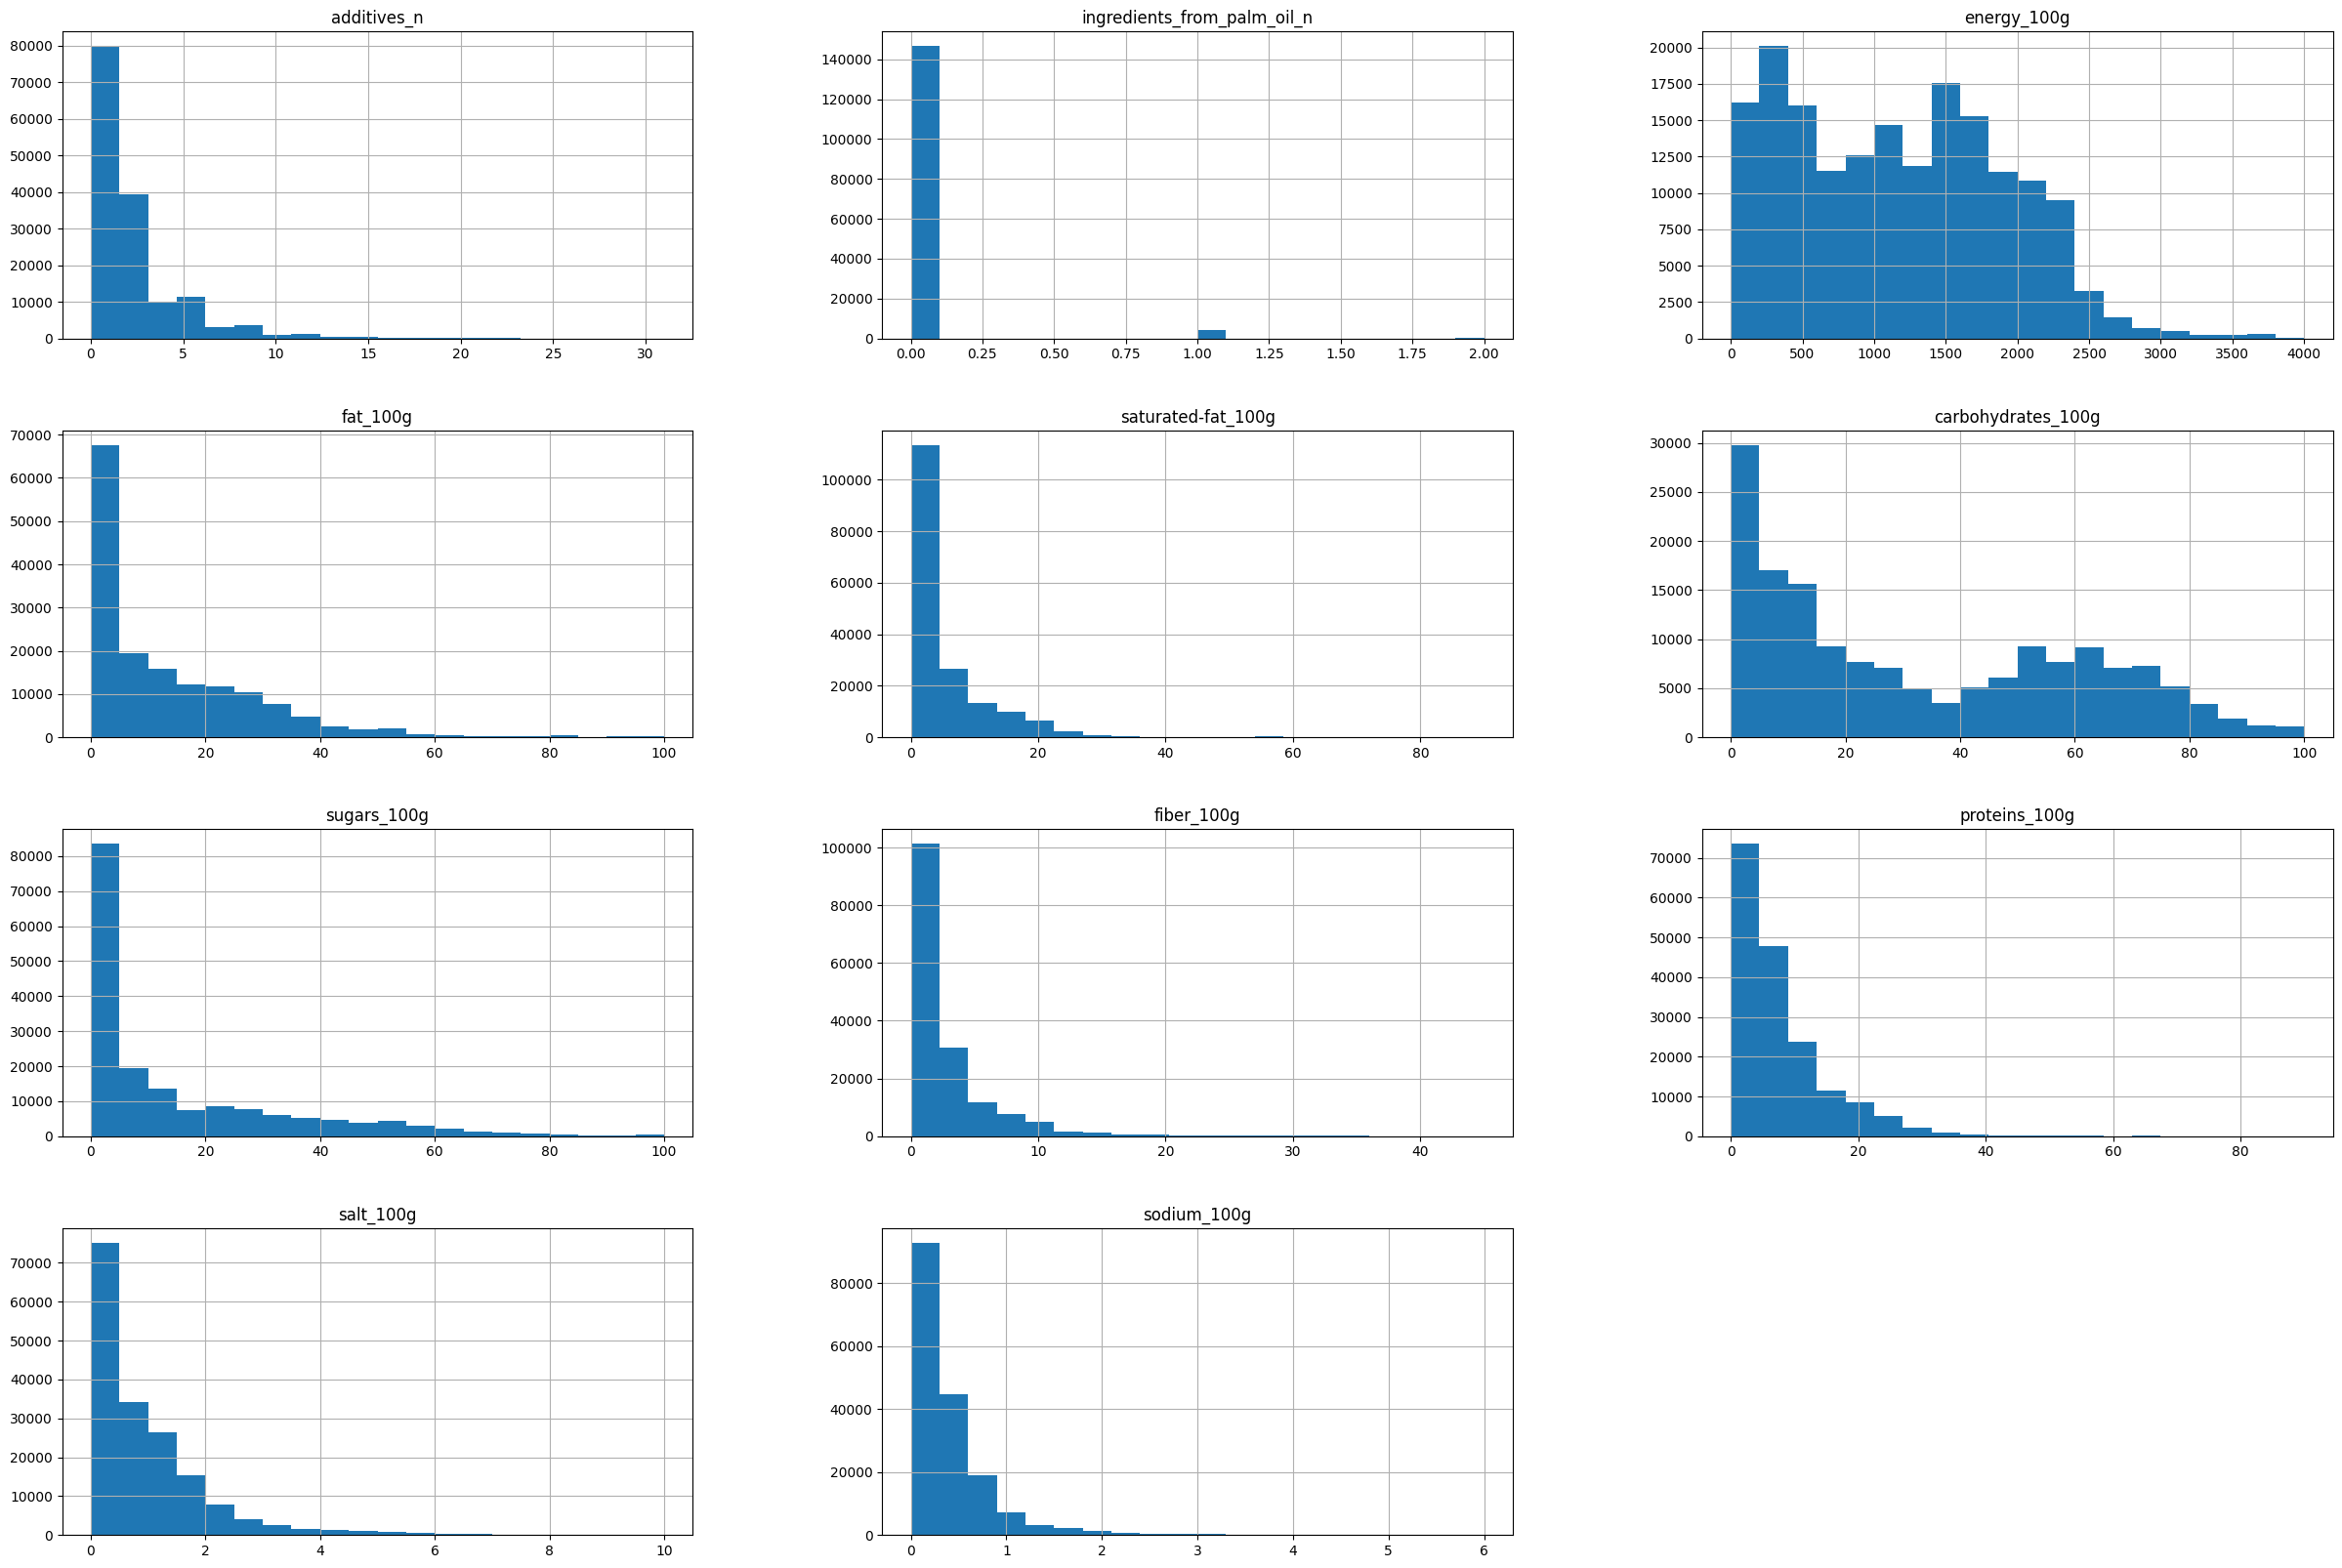

In [169]:
df_cleaned.hist(bins=20, figsize=(30, 20))
plt.show()

**Imputation par la médiane de la catégorie**

In [170]:
features_to_impute = ['fiber_100g', 'carbohydrates_100g', 'sugars_100g', 
                      'saturated-fat_100g', 'fat_100g', 'proteins_100g', 
                      'sodium_100g', 'salt_100g', 'additives_n', 'ingredients_from_palm_oil_n']

df_cleaned = impute_by_category_median(
    df_cleaned, 
    features_to_impute, 
    primary_category='pnns_groups_1', 
    secondary_category='pnns_groups_2'
)

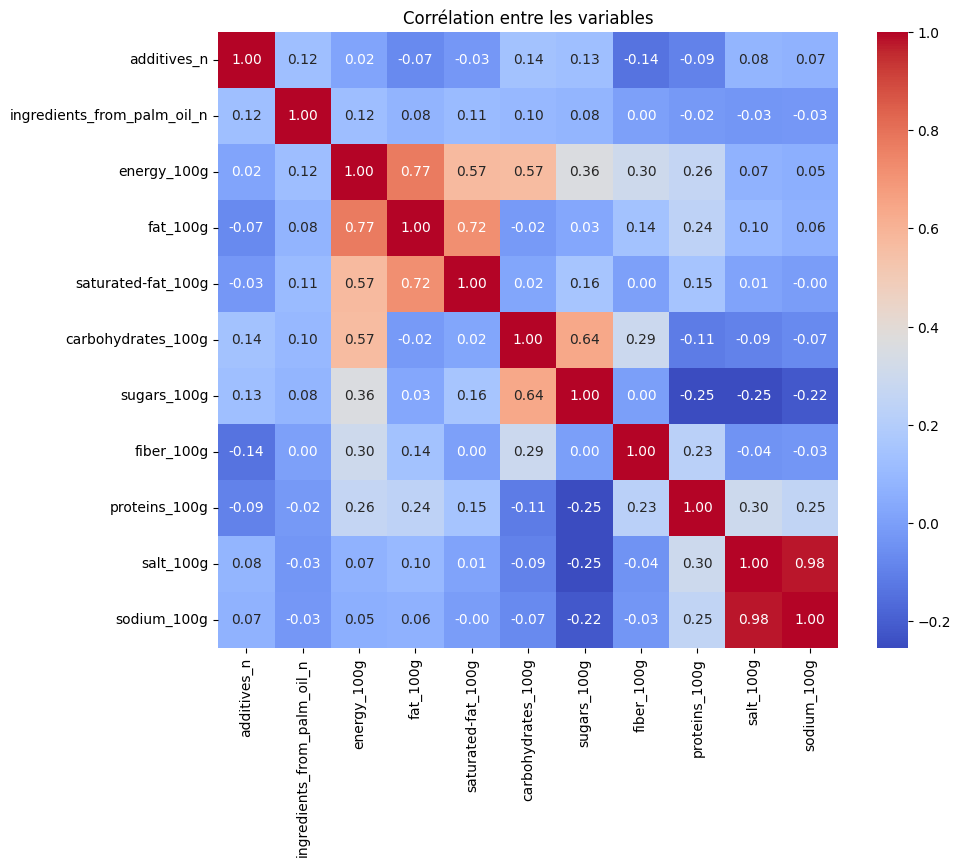

In [171]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_cleaned.select_dtypes(include=['number']).corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Corrélation entre les variables")
plt.show()

In [172]:
group1 = ['energy_100g', 'fat_100g', 'saturated-fat_100g']
group2 = ['carbohydrates_100g', 'sugars_100g']
group3 = ['sodium_100g', 'salt_100g']

In [173]:
imputer = IterativeImputer(max_iter=10, random_state=0)
df_cleaned_imputed = df_cleaned.copy()
numeric_columns = df_cleaned_imputed.select_dtypes(include=['number']).columns
nutriments_columns = ['fiber_100g', 'carbohydrates_100g', 'sugars_100g', 
                      'saturated-fat_100g', 'fat_100g', 'proteins_100g', 
                      'sodium_100g', 'salt_100g']


for group in [group1, group2, group3]:
    df_cleaned_imputed[group] = imputer.fit_transform(df_cleaned_imputed[group])

for col in ['additives_n', 'ingredients_from_palm_oil_n', 'proteins_100g', 'fiber_100g']:
    df_cleaned_imputed[col] = df_cleaned_imputed[col].fillna(df_cleaned_imputed[col].median())

numeric_columns = df_cleaned_imputed.select_dtypes(include=['number']).columns
df_cleaned_imputed[numeric_columns] = df_cleaned_imputed[numeric_columns].clip(lower=0)
df_cleaned_imputed[nutriments_columns] = df_cleaned_imputed[nutriments_columns].clip(upper=100)
df_cleaned_imputed['energy_100g'] = df_cleaned_imputed['energy_100g'].clip(upper=4000)


In [174]:
display(df_cleaned_imputed.isnull().sum())

additives_n                         0
ingredients_from_palm_oil_n         0
nutrition_grade_fr                  0
energy_100g                         0
fat_100g                            0
saturated-fat_100g                  0
carbohydrates_100g                  0
sugars_100g                         0
fiber_100g                          0
proteins_100g                       0
salt_100g                           0
sodium_100g                         0
pnns_groups_1                  128426
pnns_groups_2                  128325
dtype: int64

<Axes: >

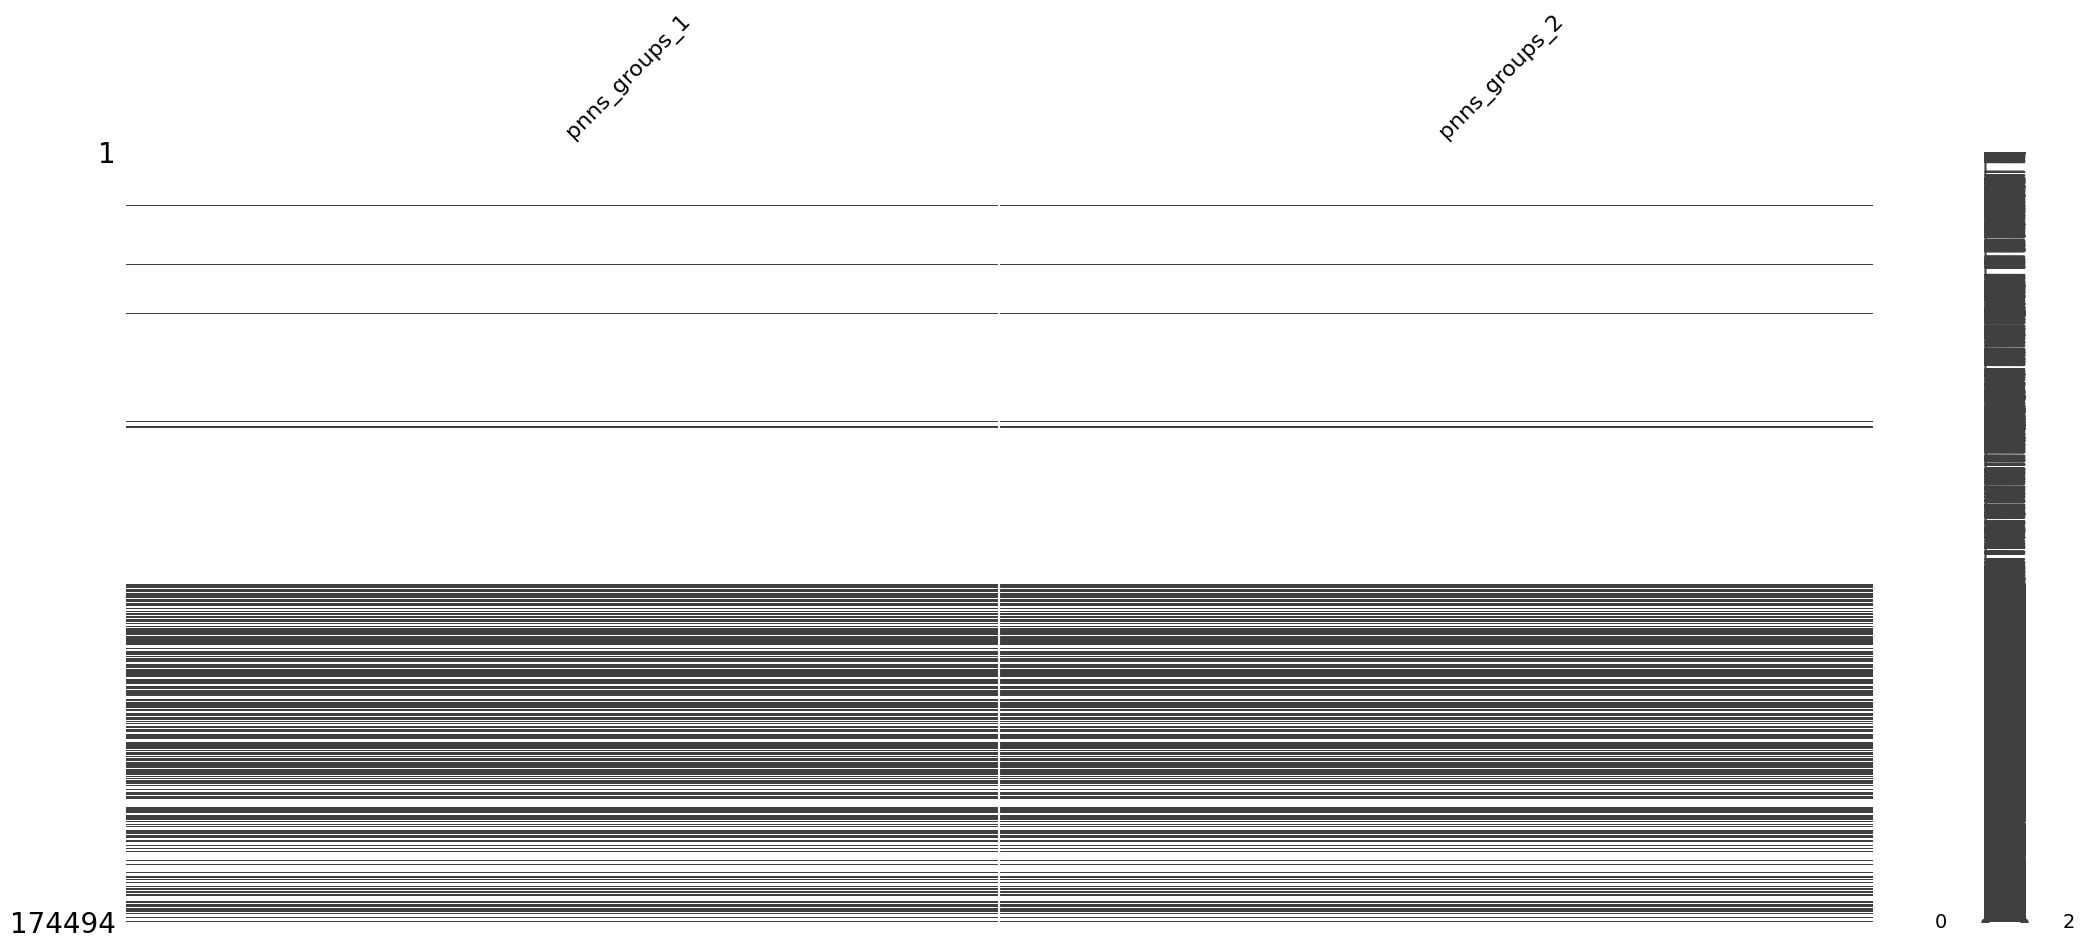

In [175]:
msno.matrix(df_cleaned_imputed[df_cleaned_imputed.columns[df_cleaned_imputed.isnull().any()]])

# Analyse Uni-Variée

In [176]:
df_cleaned_imputed.describe()

,additives_n,ingredients_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
count,174494.000000,174494.000000,174494.000000,174494.000000,174494.000000,174494.000000,174494.000000,174494.000000,174494.000000,174494.000000,174494.000000
mean,1.967879,0.023348,1169.841766,13.271452,4.971878,32.875558,15.117572,2.518648,7.598727,0.999511,0.396237
std,2.481330,0.152741,742.721673,15.142184,7.266626,26.828992,19.309023,3.849319,7.757733,1.360900,0.550883
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,482.000000,1.250000,0.000000,8.700000,1.470000,0.000000,2.200000,0.119380,0.047000
50%,1.000000,0.000000,1145.000000,8.110000,2.000000,24.690000,5.600000,1.400000,5.710000,0.680720,0.268000
75%,3.000000,0.000000,1724.000000,21.400000,7.140000,56.700000,23.600000,3.300000,10.490000,1.330960,0.525000
max,31.000000,2.000000,4000.000000,100.000000,90.000000,100.000000,100.000000,45.000000,90.000000,14.637585,6.000000


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


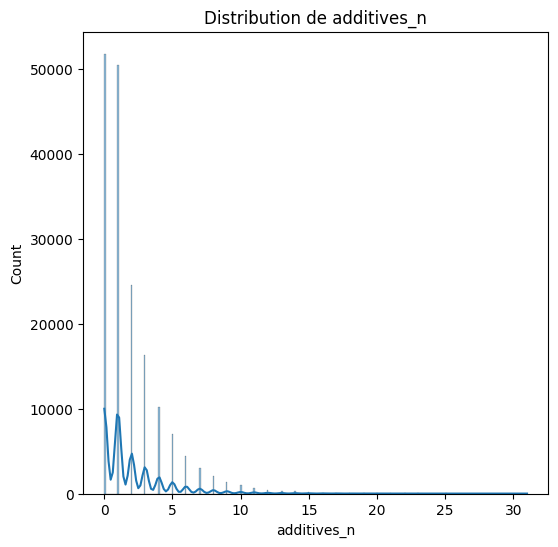

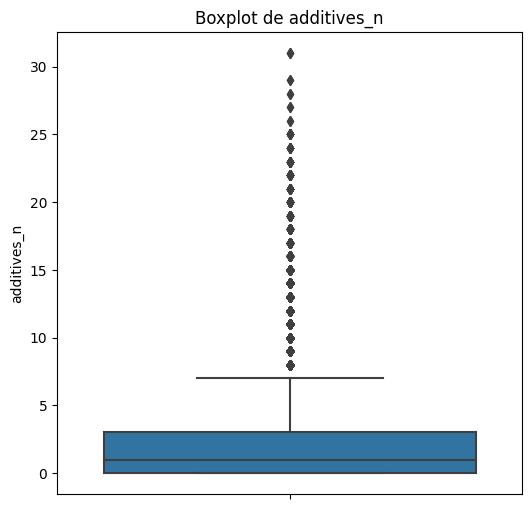

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


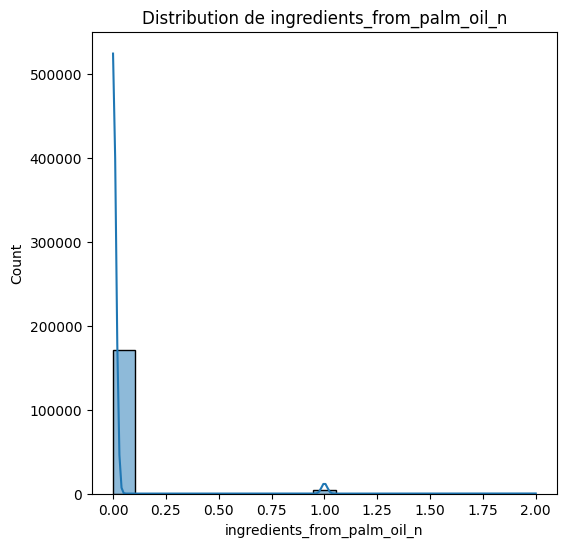

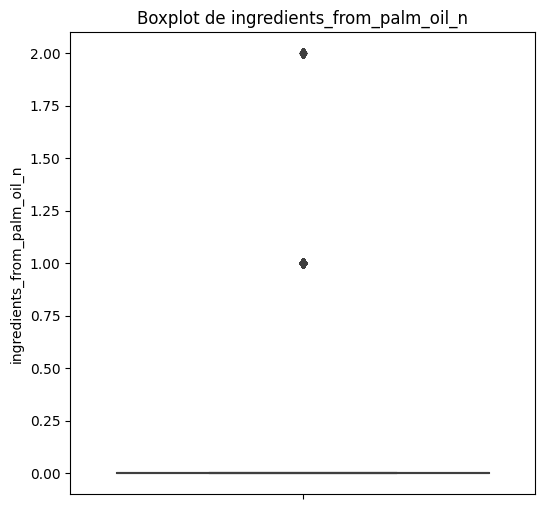

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


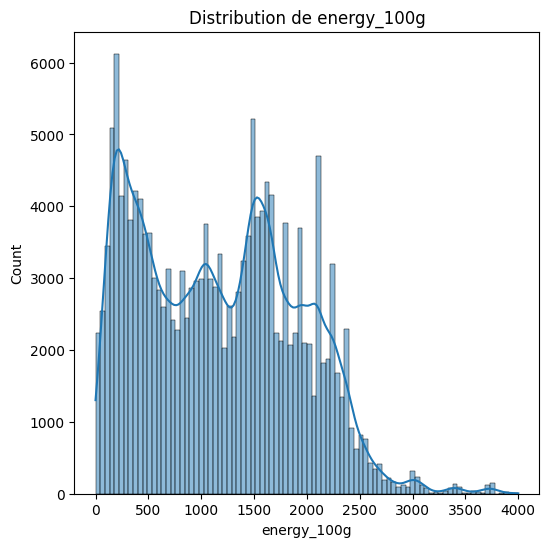

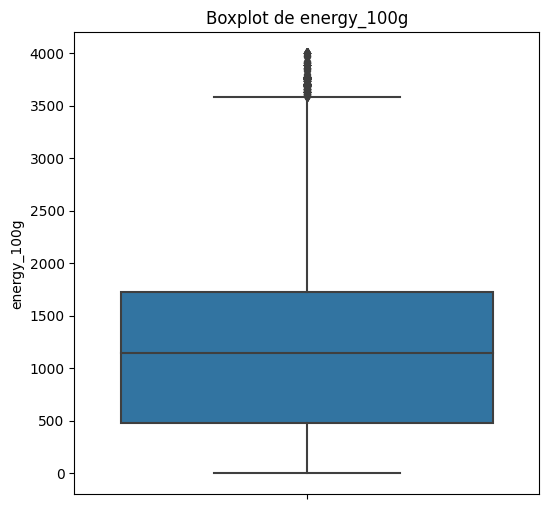

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


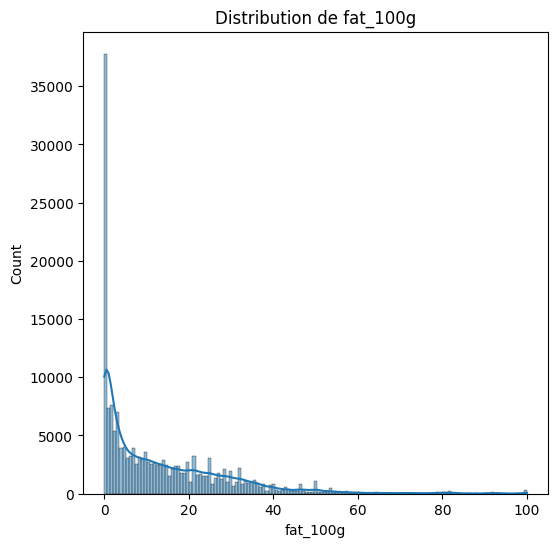

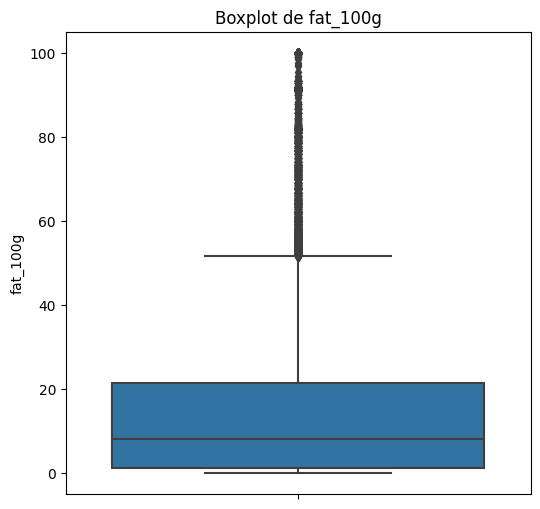

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


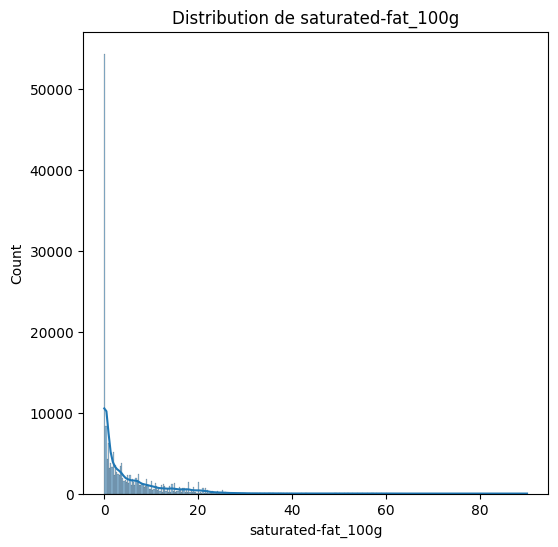

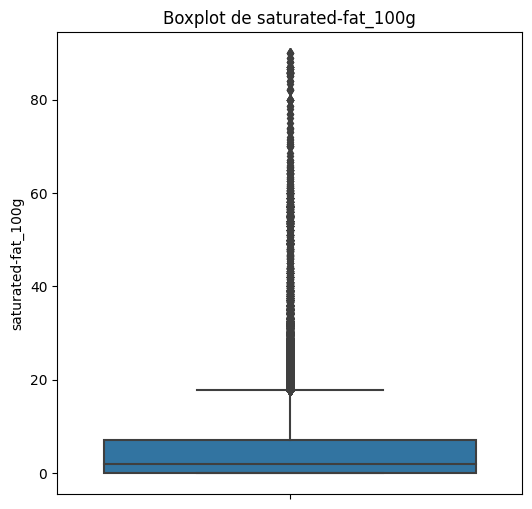

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


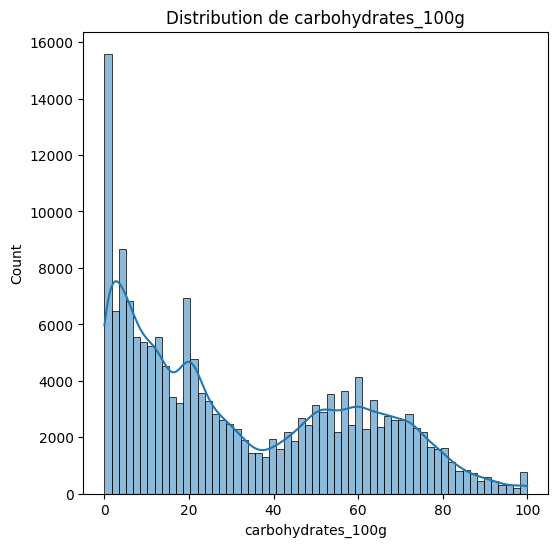

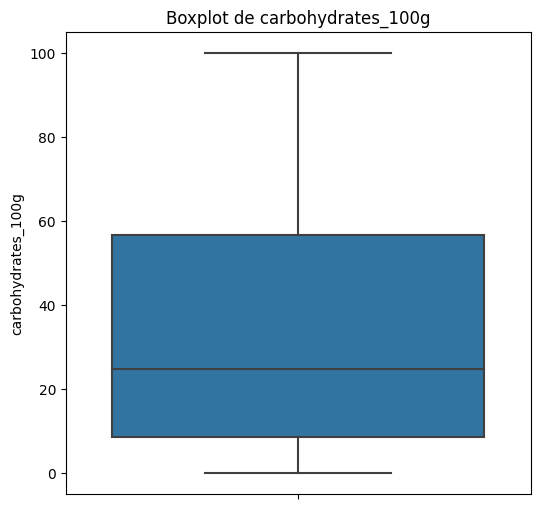

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


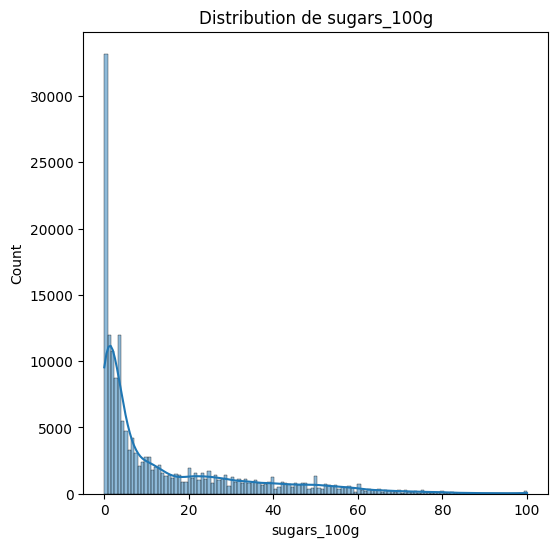

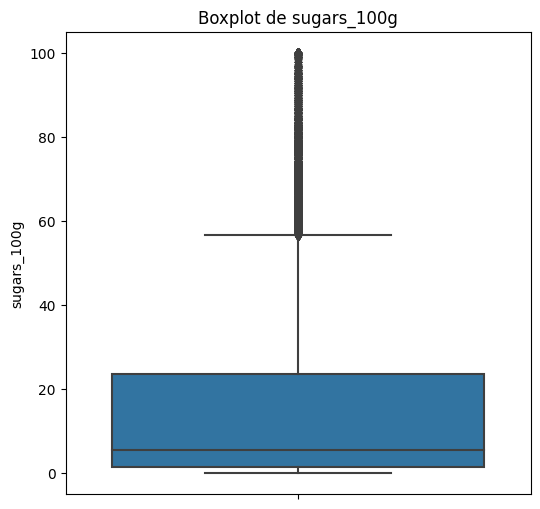

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


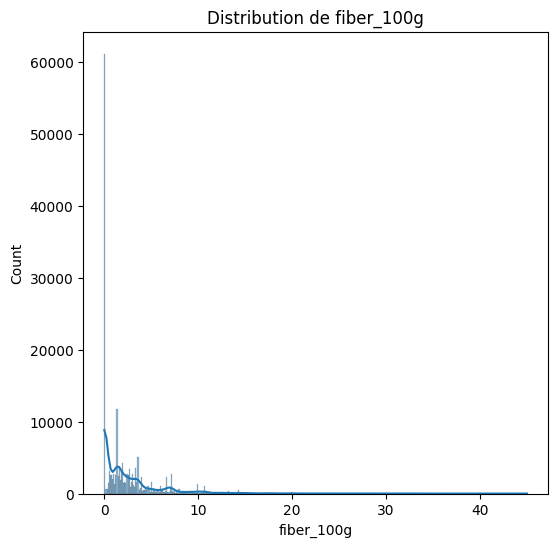

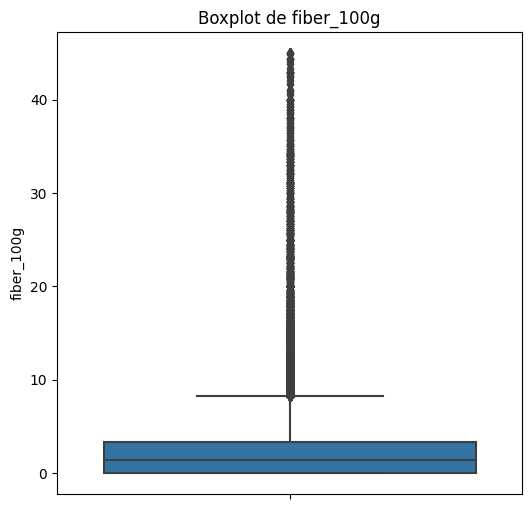

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


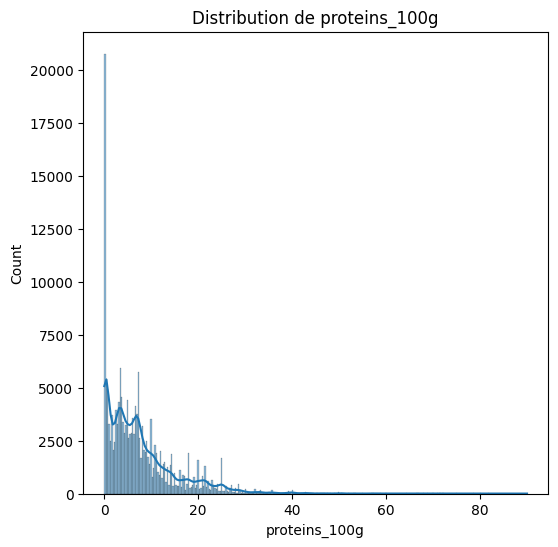

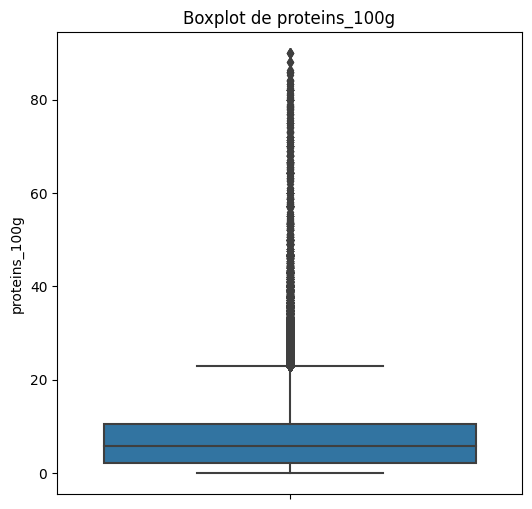

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


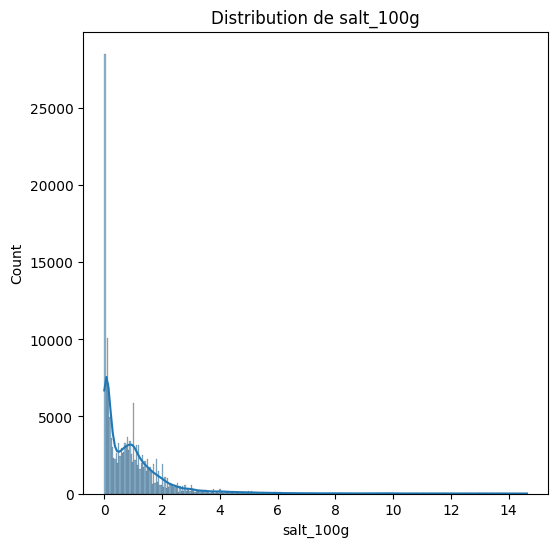

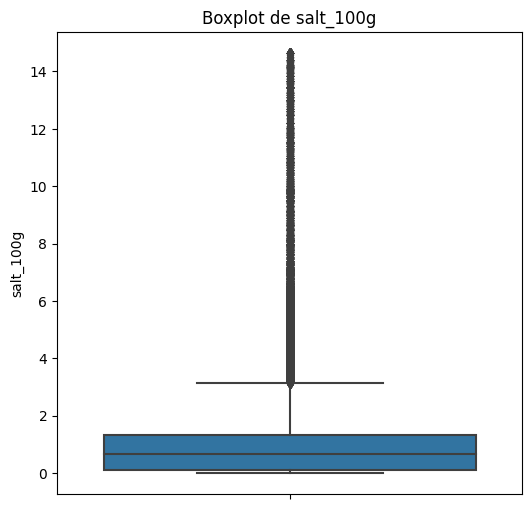

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


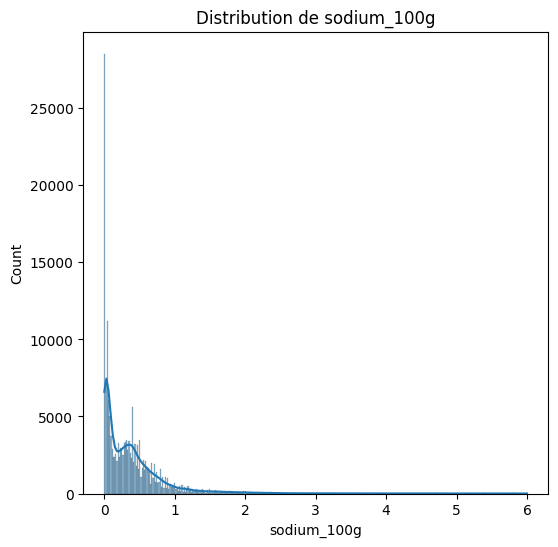

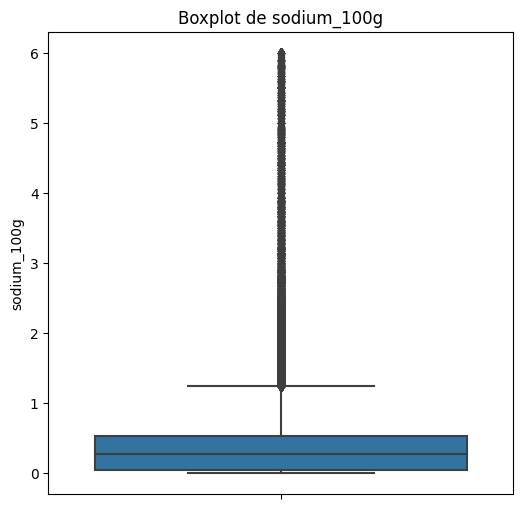

In [182]:
numeric_features = df_cleaned_imputed.select_dtypes(include=['number']).columns
categorical_features = df_cleaned_imputed.select_dtypes(include=['object']).columns

# Analyse univariée pour les features numériques
for feature in numeric_features:
    plt.figure(figsize=(6, 6))
    sns.histplot(df_cleaned_imputed[feature], kde=True)
    plt.title(f'Distribution de {feature}')
    plt.show()
    
    plt.figure(figsize=(6, 6))
    sns.boxplot(y=df_cleaned_imputed[feature])
    plt.title(f'Boxplot de {feature}')
    plt.show()

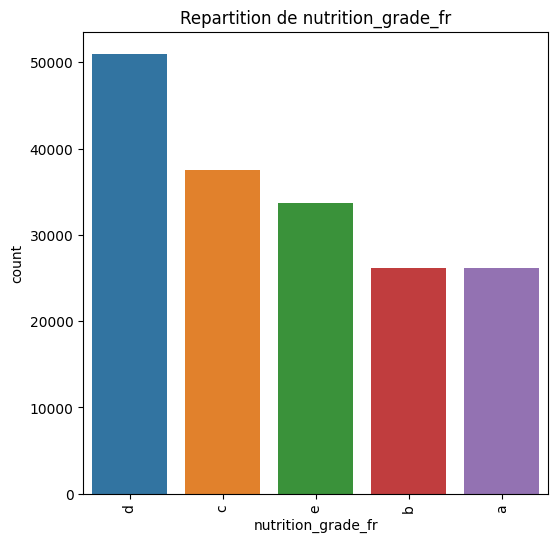

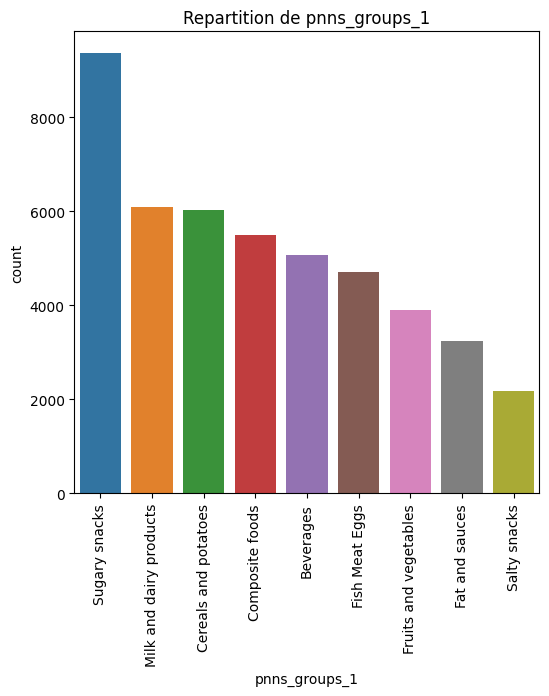

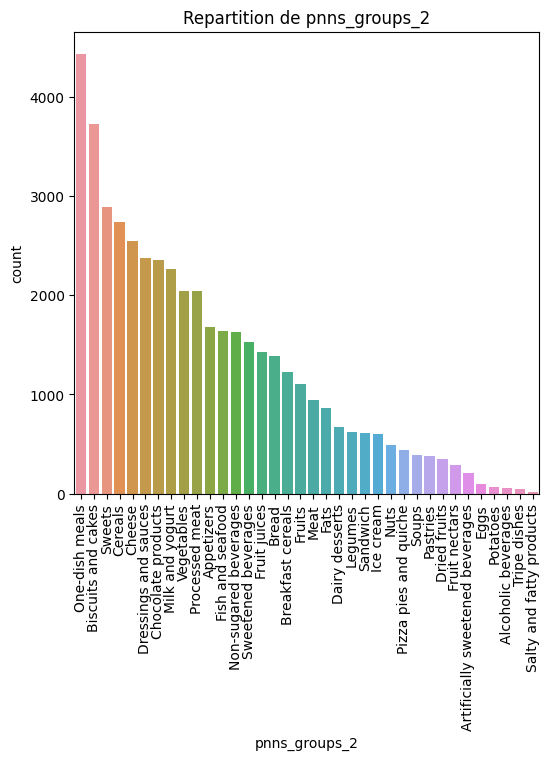

In [183]:
# Analyse univariée pour les features catégorielles
for feature in categorical_features:
    plt.figure(figsize=(6, 6))
    sns.countplot(x=df_cleaned_imputed[feature], order=df_cleaned_imputed[feature].value_counts().index)
    plt.title(f'Repartition de {feature}')
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
# Analyse bi-variée : Matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(df_cleaned_imputed[numeric_features].corr(), annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

In [ ]:
# Analyse bi-variée : Numérique vs Catégorielle
for num_feature in numeric_features:
    for cat_feature in categorical_features:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df_cleaned_imputed[cat_feature], y=df_cleaned_imputed[num_feature])
        plt.title(f'{num_feature} en fonction de {cat_feature}')
        plt.show()